# Crashes during Spring Break

Do crashes decrease during Denver Public Schools spring breaks?

In [1]:
import json
import pytz
import folium
from folium.features import DivIcon
from folium.plugins import HeatMap

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib._color_data import TABLEAU_COLORS
import seaborn as sns

import os
os.chdir('..')

pd.set_option('display.max_rows', 500)

from scripts.crash_data_analysis import CrashDataAnalysis

In [2]:
cda = CrashDataAnalysis()

## Days of Spring Breaks

* 2025: 3/24-3/31 (extra day cesar chavez day)
* 2024: 3/25-4/1 (extra day cesar chavez day)
* 2023: 3/27-4/3 (extra day cesar chavez day)
* 2022: 3/28-4/4 (extra day cesar chavez day)
* 2021: 3/29-4/2 (no extra day)
* 2020: 3/30-4/3 (also COVID, so no school)
* 2019: 3/25-2/29
* 2018: 3/26-3/30
* 2017: 3/28-4/1

In [3]:
query = """
select
to_char(reported_date at time zone 'America/Denver', 'YYYY-MM-DD') as crash_date
, count(*) as num_crashes

from crashes c

where date_part('year', reported_date at time zone 'America/Denver') > 2017

group by 1
order by 1
"""

crashes_by_day = pd.read_sql(query, cda.conn)

In [4]:
def assign_spring_break(df):
    spring_breaks = [
        [datetime(2017, 3, 28), datetime(2017, 4, 1)]
        , [datetime(2018, 3, 26), datetime(2018, 3, 30)]
        , [datetime(2019, 3, 25), datetime(2019, 3, 29)]
        , [datetime(2021, 3, 29), datetime(2021, 4, 2)]
        , [datetime(2022, 3, 28), datetime(2022, 4, 4)]
        , [datetime(2023, 3, 27), datetime(2023, 4, 3)]
        , [datetime(2024, 3, 25), datetime(2024, 4, 1)]
        , [datetime(2025, 3, 24), datetime(2025, 3, 31)]
    ]
    
    df['crash_date'] = pd.to_datetime(df['crash_date'])
    df['crash_year'] = df.crash_date.dt.year
    df['crash_month'] = df.crash_date.dt.month
    df['day_of_week'] = df['crash_date'].dt.weekday
    
    df['is_spring_break'] = 'Not Spring Break'
    for year in spring_breaks:
        df.loc[
            (
                (df.crash_date >= year[0])
                & (df.crash_date <= year[1])
                & (df.day_of_week != 5) # Saturday
                & (df.day_of_week != 6) # Sunday
            )
            , 'is_spring_break'
        ] = 'Spring Break'
        
    return df

crashes_by_day = assign_spring_break(crashes_by_day)

In [5]:
# crashes_by_day.to_csv('~/Desktop/crashes_by_day.csv', index=False)

## Counts

In [6]:
crashes_by_day.groupby('is_spring_break').size()

is_spring_break
Not Spring Break    2643
Spring Break          39
dtype: int64

In [7]:
crashes_by_day.pivot_table(
    columns='is_spring_break'
    , index='crash_year'
    , values='num_crashes'
    , aggfunc='count'
    , fill_value=0
    , margins=True
    , margins_name='Total'
)

is_spring_break,Not Spring Break,Spring Break,Total
crash_year,,,
2018,360,5,365
2019,360,5,365
2020,366,0,366
2021,360,5,365
2022,359,6,365
2023,359,6,365
2024,360,6,366
2025,119,6,125
Total,2643,39,2682


In [8]:
effect_median = crashes_by_day.pivot_table(
    index='day_of_week'
    , columns='is_spring_break'
    , values='num_crashes'
    , aggfunc='median'
)
effect_median['delta'] = effect_median['Spring Break'] - effect_median['Not Spring Break']
effect_median

is_spring_break,Not Spring Break,Spring Break,delta
day_of_week,,,
0,54.0,46.0,-8.0
1,58.0,53.0,-5.0
2,57.0,48.0,-9.0
3,59.0,51.0,-8.0
4,57.0,50.0,-7.0
5,44.0,NaN,NaN
6,41.0,NaN,NaN


In [9]:
crashes_by_day.pivot_table(
    index='day_of_week'
    , columns='is_spring_break'
    , values='num_crashes'
    , aggfunc='count'
    , margins=True
    , margins_name='Total'
    , fill_value=0
)

is_spring_break,Not Spring Break,Spring Break,Total
day_of_week,,,
0,373,11,384
1,376,7,383
2,376,7,383
3,376,7,383
4,376,7,383
5,383,0,383
6,383,0,383
Total,2643,39,2682


In [10]:
effect_alldays_median = crashes_by_day[crashes_by_day.day_of_week <= 4].pivot_table(
    columns='is_spring_break'
    , values='num_crashes'
    , aggfunc='median'
)
effect_alldays_median['delta'] = effect_alldays_median['Spring Break'] - effect_alldays_median['Not Spring Break']
effect_alldays_median

is_spring_break,Not Spring Break,Spring Break,delta
num_crashes,57,51,-6


## Plots

In [11]:
max_crash_timestamp = crashes_by_day.crash_date.max() # most recent date from query

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset, updated {max_crash_timestamp.strftime('%b %-d, %Y')}
Chart by Devin Brady
"""

print(citation)


Source: City and County of Denver "Traffic Accidents" dataset, updated May 5, 2025
Chart by Devin Brady



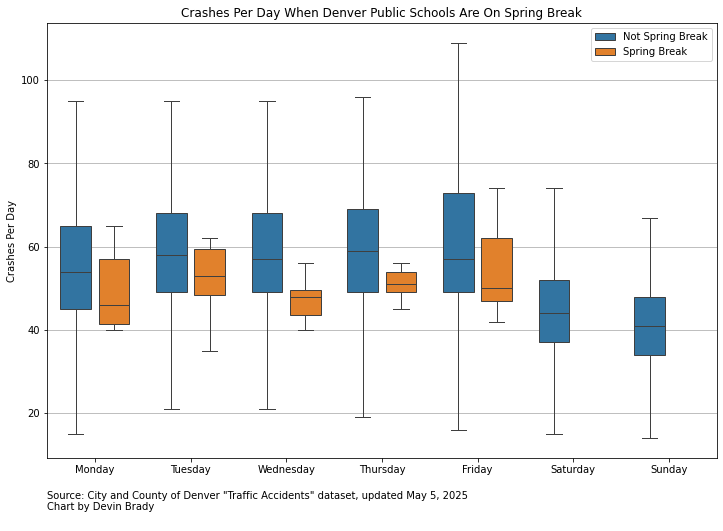

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(
    data=crashes_by_day
    , x='day_of_week'
    , y='num_crashes'
    , hue='is_spring_break'
    , ax=ax
    , showfliers=False
    , gap=0.2
)

plt.xlabel(None)
plt.ylabel('Crashes Per Day')
plt.title('Crashes Per Day When Denver Public Schools Are On Spring Break')
ax.set_xticks(
    ticks=ax.get_xticks()
    , labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
ax.grid(axis='y')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

ax.annotate(xy=(0, -0.1), text=citation, xycoords='axes fraction', ha='left', va='center')

plt.savefig('images/spring_break_boxplot.png', transparent=False, facecolor='white', bbox_inches='tight')

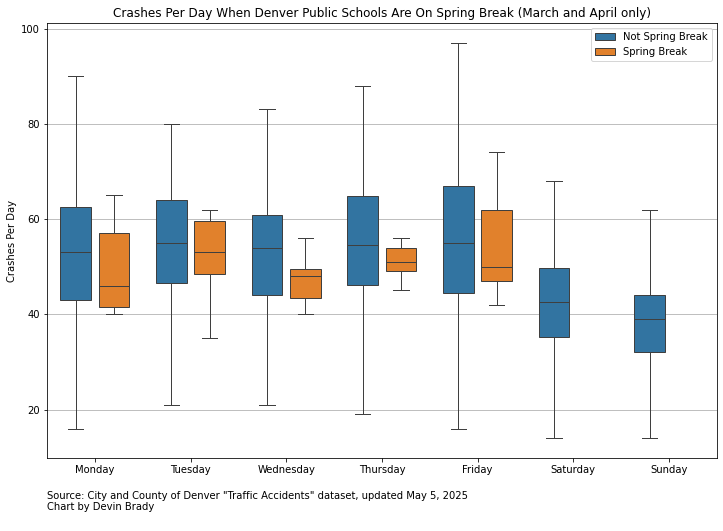

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(
    data=crashes_by_day[crashes_by_day.crash_month.isin([3,4])]
    , x='day_of_week'
    , y='num_crashes'
    , hue='is_spring_break'
    , ax=ax
    , showfliers=False
    , gap=0.2
)

plt.xlabel(None)
plt.ylabel('Crashes Per Day')
plt.title('Crashes Per Day When Denver Public Schools Are On Spring Break (March and April only)')
ax.set_xticks(
    ticks=ax.get_xticks()
    , labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
ax.grid(axis='y')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

ax.annotate(xy=(0, -0.1), text=citation, xycoords='axes fraction', ha='left', va='center')

plt.savefig(
    'images/spring_break_boxplot_march_april.png', transparent=False, facecolor='white', bbox_inches='tight')

Text(0, -0.1, '\nSource: City and County of Denver "Traffic Accidents" dataset, updated May 5, 2025\nChart by Devin Brady\n')

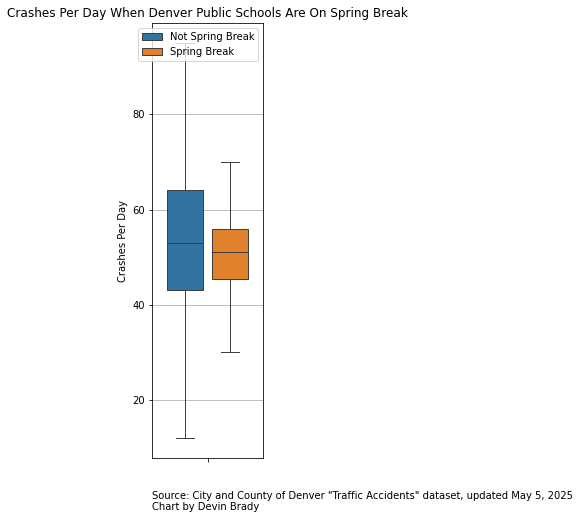

In [14]:
fig, ax = plt.subplots(figsize=(2,8))
sns.boxplot(
    data=crashes_by_day
    , y='num_crashes'
    , hue='is_spring_break'
    , ax=ax
    , showfliers=False
    , gap=0.2
)

plt.xlabel(None)
plt.ylabel('Crashes Per Day')
plt.title('Crashes Per Day When Denver Public Schools Are On Spring Break')
# ax.set_xticks(
#     ticks=ax.get_xticks()
#     , labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# )
ax.grid(axis='y')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

ax.annotate(xy=(0, -0.1), text=citation, xycoords='axes fraction', ha='left', va='center')

## Hours of the Day

In [15]:
query = """
select
to_char(reported_date at time zone 'America/Denver', 'YYYY-MM-DD') as crash_date
, to_char(reported_date at time zone 'America/Denver', 'YYYY-MM-DD HH24') as crash_date_hour
, count(*) as num_crashes

from crashes c

where date_part('year', reported_date at time zone 'America/Denver') > 2017

group by 1,2
order by 2
"""

crashes_by_day_hour = pd.read_sql(query, cda.conn)

In [16]:
crashes_by_day_hour['crash_date_hour'] = pd.to_datetime(crashes_by_day_hour['crash_date_hour'])
crashes_by_day_hour['hour'] = crashes_by_day_hour.crash_date_hour.dt.hour

crashes_by_day_hour = assign_spring_break(crashes_by_day_hour)

# Narrow to March and April and exclude weekends
crashes_by_day_hour = crashes_by_day_hour[
    (crashes_by_day_hour.crash_month.isin([3,4]))
    & (crashes_by_day_hour.day_of_week.isin([0,1,2,3,4]))
].copy()

In [17]:
# crashes_by_day_hour.to_csv('~/Desktop/crashes_by_day_hour.csv', index=False)

Text(0, -0.1, '\nSource: City and County of Denver "Traffic Accidents" dataset, updated May 5, 2025\nChart by Devin Brady\n')

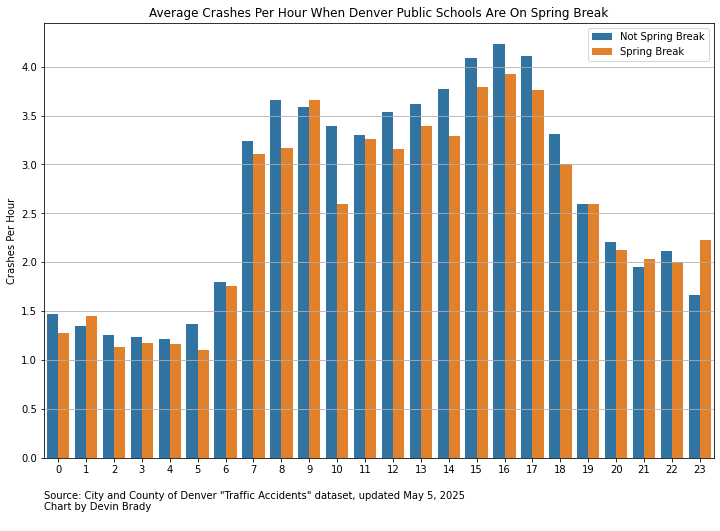

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(
    data=crashes_by_day_hour
    , x='hour'
    , y='num_crashes'
    , hue='is_spring_break'
    , ax=ax
    , errorbar=None
#     , gap=0.2
)

plt.xlabel(None)
plt.ylabel('Crashes Per Hour')
plt.title('Average Crashes Per Hour When Denver Public Schools Are On Spring Break')
ax.grid(axis='y')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

ax.annotate(xy=(0, -0.1), text=citation, xycoords='axes fraction', ha='left', va='center')

# plt.savefig('images/spring_break_boxplot.png', transparent=False, facecolor='white', bbox_inches='tight')

In [19]:
crashes_by_day_hour.pivot_table(
    index='hour'
    , columns='is_spring_break'
    , values='num_crashes'
    , aggfunc='count'
    , margins=True
    , margins_name='Total'
    , fill_value=0
)

is_spring_break,Not Spring Break,Spring Break,Total
hour,,,
0,173,29,202
1,118,20,138
2,130,15,145
3,95,17,112
4,87,12,99
5,118,19,137
6,213,25,238
7,281,37,318
8,286,36,322


In [20]:
effect_hour_avg = crashes_by_day_hour.pivot_table(
    index='hour'
    , columns='is_spring_break'
    , values='num_crashes'
    , aggfunc='mean'
    , margins=True
)

effect_hour_avg['delta'] = effect_hour_avg['Spring Break'] - effect_hour_avg['Not Spring Break']
effect_hour_avg

is_spring_break,Not Spring Break,Spring Break,All,delta
hour,,,,
0,1.473988,1.275862,1.445545,-0.198126
1,1.347458,1.450000,1.362319,0.102542
2,1.261538,1.133333,1.248276,-0.128205
3,1.231579,1.176471,1.223214,-0.055108
4,1.218391,1.166667,1.212121,-0.051724
5,1.364407,1.105263,1.328467,-0.259144
6,1.798122,1.760000,1.794118,-0.038122
7,3.234875,3.108108,3.220126,-0.126767
8,3.660839,3.166667,3.605590,-0.494172


## Aggregate time into buckets

In [21]:
bins_4 = [0, 6, 12, 18, 24]
labels_4 = ['1) Midnight to 7am', '2) 7am to 12pm', '3) 12pm to 7pm', '4) 7pm to Midnight']
crashes_by_day_hour['hour_bucket_4'] = pd.cut(crashes_by_day_hour['hour'], bins=bins_4, labels=labels_4)

bins_6 = [0, 4, 8, 12, 16, 20, 24]
labels_6 = ['1) Midnight to 5am', '2) 5am to 9am', '3) 9am to 1pm', '4) 1pm to 5pm', '5) 5pm to 9pm', '6) 9pm to Midnight']
crashes_by_day_hour['hour_bucket_6'] = pd.cut(crashes_by_day_hour['hour'], bins=bins_6, labels=labels_6)

In [22]:
crashes_by_day_hour.groupby('hour_bucket_4').agg(min_hour=('hour','min'), max_hour=('hour','max'))

,min_hour,max_hour
hour_bucket_4,,
1) Midnight to 7am,1,6
2) 7am to 12pm,7,12
3) 12pm to 7pm,13,18
4) 7pm to Midnight,19,23


In [23]:
crashes_by_day_hour.groupby('hour_bucket_6').agg(min_hour=('hour','min'), max_hour=('hour','max'))

,min_hour,max_hour
hour_bucket_6,,
1) Midnight to 5am,1,4
2) 5am to 9am,5,8
3) 9am to 1pm,9,12
4) 1pm to 5pm,13,16
5) 5pm to 9pm,17,20
6) 9pm to Midnight,21,23


In [24]:
buckets = [4,6]
bucket_df = {}

for b in buckets:
    bucket_df[b] = crashes_by_day_hour.groupby(['crash_date', f'hour_bucket_{b}']).num_crashes.sum().reset_index()
    bucket_df[b] = assign_spring_break(bucket_df[b])

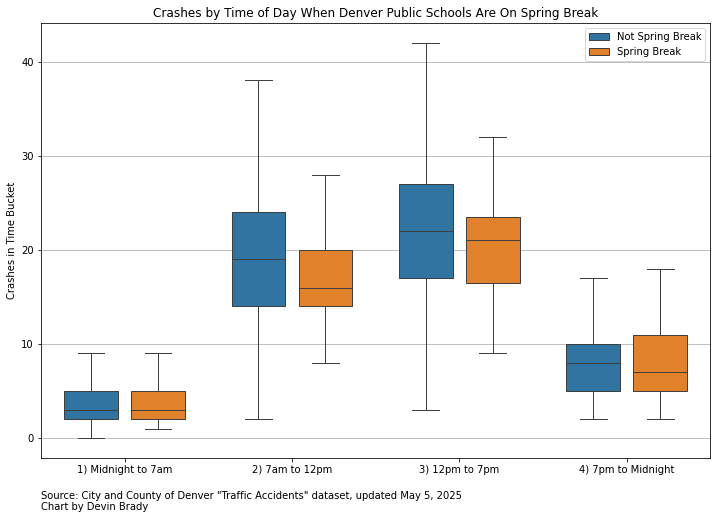

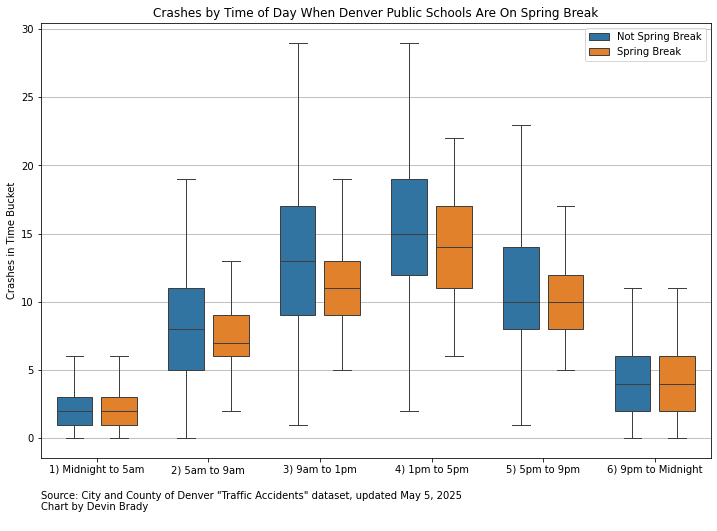

In [25]:
for b in buckets:
    fig, ax = plt.subplots(figsize=(12,8))
    sns.boxplot(
        data=bucket_df[b]
        , x=f'hour_bucket_{b}'
        , y='num_crashes'
        , hue='is_spring_break'
        , ax=ax
        , showfliers=False
        , gap=0.2
    )

    plt.xlabel(None)
    plt.ylabel('Crashes in Time Bucket')
    plt.title('Crashes by Time of Day When Denver Public Schools Are On Spring Break')
    ax.grid(axis='y')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)

    ax.annotate(xy=(0, -0.1), text=citation, xycoords='axes fraction', ha='left', va='center')

    plt.savefig(f'images/spring_break_boxplot_{b}_buckets.png', transparent=False, facecolor='white', bbox_inches='tight')

In [26]:
for b in buckets:
    print(
        bucket_df[b].pivot_table(
            index=f'hour_bucket_{b}'
            , columns='is_spring_break'
            , values='num_crashes'
            , aggfunc='median'
        )
    )
    print()

is_spring_break     Not Spring Break  Spring Break
hour_bucket_4                                     
1) Midnight to 7am                 3             3
2) 7am to 12pm                    19            16
3) 12pm to 7pm                    22            21
4) 7pm to Midnight                 8             7

is_spring_break     Not Spring Break  Spring Break
hour_bucket_6                                     
1) Midnight to 5am                 2             2
2) 5am to 9am                      8             7
3) 9am to 1pm                     13            11
4) 1pm to 5pm                     15            14
5) 5pm to 9pm                     10            10
6) 9pm to Midnight                 4             4



In [27]:
# todo: estimate the number of crashes eliminated by spring break day
# todo: look at fatalities, SBI, bike, and pedestrians